In [41]:
# imports
# basic
import numpy as np
from flatland.envs.rail_env import RailEnv
# for rendering
import PIL
from flatland.utils.rendertools import RenderTool
from IPython.display import clear_output
# for plotting
import matplotlib.pyplot as plt
# for running clingo
import json
import subprocess
import os
import pickle

# Functions

In [42]:
# render the environment
def render_env(env,wait=True):
    
    env_renderer = RenderTool(env, gl="PILSVG")
    env_renderer.render_env()

    image = env_renderer.get_image()
    pil_image = PIL.Image.fromarray(image)
    pil_image = pil_image.convert("RGB")
    clear_output(wait=True)
    display(pil_image)

## Export

In [43]:
# get global transitions
def get_transitions(obsx):
    transitions = obsx[0][0]
    x = 0
    atoms = []

    for i in transitions:
        y = 0
        for j in i:
            directions = ["(\"N\",\"N\")", "(\"N\",\"E\")", "(\"N\",\"S\")", "(\"N\",\"W\")", "(\"E\",\"N\")", "(\"E\",\"E\")", "(\"E\",\"S\")", "(\"E\",\"W\")", "(\"S\",\"N\")", "(\"S\",\"E\")", "(\"S\",\"S\")", "(\"S\",\"W\")", "(\"W\",\"N\")", "(\"W\",\"E\")", "(\"W\",\"S\")", "(\"W\",\"W\")"]
            usableDirections = [directions[i] for i, bit in enumerate(j) if bit == 1]

            for k in usableDirections:
                atoms.append(f"transition(({x},{y}),{k})")
            y += 1
        x += 1

    return atoms

In [44]:
# extract info of an agent
def get_agents(agent):
    atoms = []

    # state(A,(X,Y),T,D)
    # A - agent handle
    # (X,Y) - position of the agent
    # T - time til earliest departure
    # D - direction "N", "E", "S" or "W"
    directions = {0:"\"N\"", 1:"\"E\"", 2:"\"S\"", 3:"\"W\""}
    initialstate = "initialstate(" + str(agent.handle) + ", " + str(agent.initial_position) + ", " + str(agent.earliest_departure) + ", " + str(directions[agent.direction]) + ")"
    atoms.append(initialstate)

    # target(A,(X,Y),T)
    # A - agent handle
    # (X,Y) - position of the target
    # T - time til latest arrival
    target = "target(" + str(agent.handle) + ", "+str(agent.target) + ", " + str(agent.latest_arrival) + ")"
    atoms.append(target)

    # speed(A,S)
    # A - agent handle
    # S - steps taken for one transition
    speed = "speed(" + str(agent.handle) + ", " + str(agent.speed_counter.max_count+1) + ")"
    atoms.append(speed)

    return(atoms)

In [45]:
# get all atoms combined (agents and transitions)
def get_atoms(env,obs,filename):
    # get atoms
    agent_handles = env.get_agent_handles()
    atoms = get_transitions(obs[agent_handles[0]])
    for i in agent_handles:
        atoms = atoms + get_agents(env.agents[i])

    # export atoms
    atoms.append("")
    output = ". ".join(atoms)
    with open(filename, "w") as file:
        file.write(output)

## Import

In [46]:
# inputs are given as file names
def get_orders(input, encoding):
    # Define the command to run
    command = "clingo " + input + " " + encoding + " --outf=2 | jq '.'"

    # Run the command and capture its output
    try:
        output_bytes = subprocess.check_output(command, shell=True)
        output = output_bytes.decode('utf-8')
        data = json.loads(output)
    except subprocess.CalledProcessError as e:
        print(f"Command failed with error: {e}")
        return None
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON: {e}")
        return None

    if data is not None:
        # Extract the "Value" field
        values = data["Call"][0]["Witnesses"][0]["Value"]

        # Initialize a dictionary to store the dictionaries
        dictionaries = {}

        # Iterate through the values
        for value in values:
            parts = value.split(",")
            x = int(parts[0].split("(")[1])
            t = int(parts[1])
            d = parts[2].strip(")\"")

            # Create a dictionary for x if it doesn't exist
            if x not in dictionaries:
                dictionaries[x] = {}

            # Add the corresponding d to the dictionary with t as the key
            dictionaries[x][t] = d

        return dictionaries

    return None

In [47]:
# run the orders
def run_orders(env, orders):
    t = 0

    while True:
        dictionary = {}
        for i in orders:
            if t in orders[i]: value = orders[i][t]
            else: value = 0
            dictionary[i] = int(value)
        print(str(t) + ": "+ str(dictionary))
    
        obs, rew, done, info = env.step(dictionary)
        render_env(env,True)

        if done["__all__"]: break

        t += 1


In [48]:
def run_manually(env):
    while True:
        dictionary = {}
        for i in env.get_agent_handles():
            print("Order for agent " + str(i) + ":")
            order = input()
            if order: dictionary[i] = int(order)
            else: dictionary[i] = 0
    
        obs, rew, done, info = env.step(dictionary)
        render_env(env,True)

        if done["__all__"]: break

# Execution

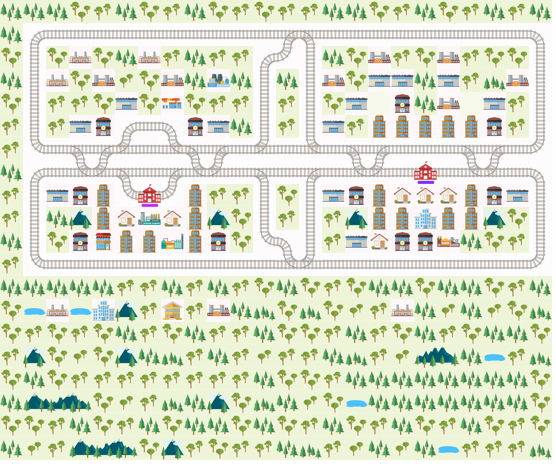

{3: {46: '3', 36: '2', 44: '2', 29: '2', 22: '2', 21: '2', 40: '4', 31: '4', 24: '4'}, 0: {46: '3', 5: '3', 45: '2', 16: '2', 7: '2', 3: '2', 44: '4', 15: '4', 6: '4', 2: '2'}, 1: {42: '3', 32: '3', 10: '3', 46: '2', 28: '2', 12: '2', 9: '2', 5: '2', 39: '4', 43: '4', 27: '4', 11: '4', 7: '4', 4: '2'}, 2: {48: '1', 45: '1', 30: '1', 36: '2', 43: '2', 7: '2', 6: '2', 39: '4', 33: '4', 28: '4'}}


In [49]:
env = RailEnv(width=24, height=20, number_of_agents=4)

with open("test.pkl", "wb") as file:
    pickle.dump(env, file)

with open("test.pkl", "rb") as file:
    env2 = pickle.load(file)

obs = env2.reset()
render_env(env2,True)

get_atoms(env2,obs,"encodings/atoms.lp")
orders = get_orders("encodings/atoms.lp","encodings/multiplePath/combined.lp")
print(orders)

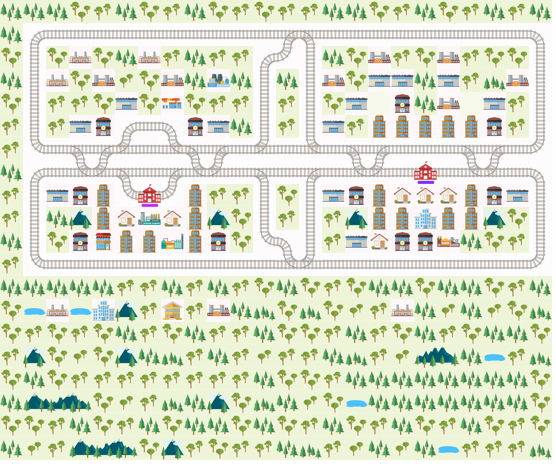

In [50]:
# run_manually(env)
run_orders(env2,orders)
# os.remove("encodings/atoms.lp")